In [40]:
import pandas as pd
df1 = pd.read_csv('path',usecols=['content','category'],encoding='ISO-8859-1')
df2 = pd.read_csv('path',usecols=['content','category'],encoding='ISO-8859-1')
df3 = pd.read_csv('path',usecols=['content','category'],encoding='ISO-8859-1')
frames = [df1, df2, df3]
df=pd.concat(frames)

In [41]:
#Assign category id to industry(DB model -->category_id)
from io import StringIO
col = ['content', 'category']
df = df[col]
df = df[pd.notnull(df['content'])]
df.columns = ['content', 'category']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()
#df.to_csv

,content,category,category_id
0,"It was a warm few days of visiting, walking ar...",agriculture,0
1,The Japanese government has ended its temporar...,agriculture,0
2,Ontario Sheep Farmers is once again offering i...,agriculture,0
3,Ontarioâs new provincial government is offic...,agriculture,0
4,Prime Minister Justin Trudeau unveiled the cab...,agriculture,0


In [42]:
category_to_id

{'agriculture': 0, 'others': 2, 'retail': 1}

In [43]:
#apply tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
import pickle
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
#tfidf = TfidfTransformer()
features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape
# save your model in disk
joblib.dump(tfidf, 'path_pkl') 

# load your model
tfidf = joblib.load('path_pkl') 

In [44]:
#unigrams and bigrams for each category
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for content, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(content))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'agriculture':
  . Most correlated unigrams:
. agriculture
. farmers
  . Most correlated bigrams:
. farms com
. national ffa
# 'others':
  . Most correlated unigrams:
. trump
. cnn
  . Most correlated bigrams:
. donald trump
. breaking news
# 'retail':
  . Most correlated unigrams:
. retailers
. retail
  . Most correlated bigrams:
. prime day
. customer experience


In [45]:
#Multinomial Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [46]:
#test with an article
print(clf.predict(count_vect.transform(["Seeding is nearly complete in Saskatchewan, with 91 per cent of the 2018 crop now in the ground.Saskatchewan Agriculture said Thursday this is well ahead of the five-year average of 81 per cent.Furthest along is the southwest region at 95 per cent. Other areas range from 93 per cent in the southeast, to 86 per cent in the east-central region."])))


['retail']


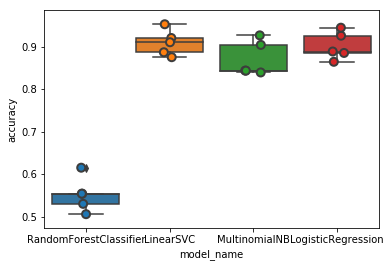

In [47]:
##apply different classifiers
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [48]:
#check accuracy
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.908764
LogisticRegression        0.901388
MultinomialNB             0.871156
RandomForestClassifier    0.551814
Name: accuracy, dtype: float64

In [49]:
#Apply linearSVC
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
clf=model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.show()

In [50]:
#Check confusion matrix
conf_mat#(for 3 categories)

array([[484,   4,  10],
       [  2, 715,  17],
       [  7,  30, 566]], dtype=int64)

In [51]:
#dump pickle
import pickle
filename = 'path_sav'
pickle.dump(model, open(filename, 'wb'))

In [52]:
model.fit(features, labels)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [26]:
#check unigrams,bigrams
from sklearn.feature_selection import chi2


N = 2
for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Agriculture':
  . Top unigrams:
       . agriculture
       . farmers
  . Top bigrams:
       . department agriculture
       . agriculture department
# 'Others':
  . Top unigrams:
       . advertisement
       . cnbc
  . Top bigrams:
       . year old
       . president donald
# 'Retail':
  . Top unigrams:
       . retail
       . retailers
  . Top bigrams:
       . retail sales
       . retail politics


In [61]:
#### Classify function(pass data from DB when classify job runs)
def classify(texts):
    text_features = tfidf.transform(text)
    loaded_model = pickle.load(open(filename, 'rb'))
    predictions = loaded_model.predict(text_features)
    for text, predicted in zip(text, predictions):
     print('"{}"'.format(text))
     print("  - Predicted as: '{}'".format(id_to_category[predicted]))
     print("")

In [53]:
#### Test classify function
texts=["""   Home » Grass » Collective industry approach needed to mitigate fodder challenges – Creed Minister for Agriculture, Food and the Marine Michael Creed has given an update on the fodder situation, following a meeting today with the Fodder Coordination Group and the release of the fodder census results. The meeting today (Thursday, July 19) is the third occasion the group has met since the start of the current dry spell. The minister started by commending the ongoing efforts of the group and its work to mitigate the effects of the current dry period on grazing and fodder supplies. Continuing, Minister Creed said: “Practical advice being shared across the group on dealing both with the current weather and also on filling the fodder gap that has now been identified is critical to our managing this challenge. “In light of potential shortfalls in fodder identified in the first fodder survey, the overall priority must be to conserve as much feed for the coming winter when the opportunity to do so arises and to take advantage of growth when it resumes after the current drought.” The minister reiterated, given the challenge, the absolute need for a collective approach – urging everyone to support and participate actively in efforts targeted to mitigate the impacts of the extended dry conditions nationwide. In this regard, he emphasised the positive role for industry and banking representatives on the fodder group. Advertisement Minister Creed welcomed the initiatives taken to date which include: the availability of an advisory helpline for farmers, with direct access to Teagasc advisors on: 087-7971377
"""]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"   Home » Grass » Collective industry approach needed to mitigate fodder challenges – Creed Minister for Agriculture, Food and the Marine Michael Creed has given an update on the fodder situation, following a meeting today with the Fodder Coordination Group and the release of the fodder census results. The meeting today (Thursday, July 19) is the third occasion the group has met since the start of the current dry spell. The minister started by commending the ongoing efforts of the group and its work to mitigate the effects of the current dry period on grazing and fodder supplies. Continuing, Minister Creed said: “Practical advice being shared across the group on dealing both with the current weather and also on filling the fodder gap that has now been identified is critical to our managing this challenge. “In light of potential shortfalls in fodder identified in the first fodder survey, the overall priority must be to conserve as much feed for the coming winter when the opportunity to